In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import time
import torch

use_wandb = True
if use_wandb:
    import wandb, os
    os.environ['WANDB_NOTEBOOK_NAME'] = 'RNN_polar.ipynb'
    wandb.init(project="transient_mac1", notes="")
    wandb.run.name = 'intp10_2_400_random_start'

In [2]:
from mac1 import Machine1

mac1 = Machine1(n_layers=2, hidden_dim=1600, n_training_sample=400, data_len=700, batchsize=200, data_interpolation_rate=5)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {mac1.model.n_layers} layers and totaling {count_parameters(mac1.model):,} trainable parameters.')

# load_file = '6_22_2020.pt'
# load_file = 'saved_models/txfxwfte/400.pt'
# load_file = 'wandb/run-20200610_141648-sm4rtc9t/model.pt'
if 'load_file' in locals():
    mac1.load_pretrained(load_file)

if use_wandb:
    wandb.config.teacher_forcing = mac1.teacher_forcing_ratio
    wandb.config.teacher_forcing_ratio_decay = mac1.teacher_forcing_ratio_decay

    wandb.config.architecture = 'LSTM'#mac1.architecture
    wandb.config.n_layers = 2#mac1.n_layers
    wandb.config.hidden_dim = 400#mac1.hidden_dim

    wandb.config.training_sample = mac1.n_training_sample
    wandb.config.data_len = mac1.data_len
    wandb.config.apply_mac_ang_filter = True#mac1.apply_mac_ang_filter
    wandb.config.angle_setting = 'Polar, unwarp'

#     loss, _ = self.test(self.train_data_torch, self.train_label_torch)
#     loss_test, _ = self.test(self.test_data_torch, self.test_label_torch)
#     rse = self.evaluation(self.test_data_torch, self.test_label_raw)
#     wandb.log({"Epoch": i, "Train Loss": loss, "Test Loss": loss_test, 'Eval RSE':np.median(rse,axis=0).mean()})

GPU is available. Deploying GPU.
The model has 2 layers and totaling 1,946,807 trainable parameters.


20:52:31  ETA:3.5mins Epoch 10: train Loss = 8.517e-02, test Loss = 9.048e-02, eval = 6.760e-01
20:52:46  ETA:3.3mins Epoch 20: train Loss = 3.436e-02, test Loss = 3.774e-02, eval = 4.986e-01
20:53:02  ETA:3.1mins Epoch 30: train Loss = 2.692e-02, test Loss = 3.044e-02, eval = 3.302e-01
20:53:17  ETA:2.8mins Epoch 40: train Loss = 1.467e-02, test Loss = 1.759e-02, eval = 2.566e-01
20:53:32  ETA:2.5mins Epoch 50: train Loss = 1.091e-02, test Loss = 1.320e-02, eval = 2.660e-01
20:53:47  ETA:2.3mins Epoch 60: train Loss = 7.520e-03, test Loss = 1.040e-02, eval = 3.399e-01
20:54:01  ETA:2.0mins Epoch 70: train Loss = 5.852e-03, test Loss = 9.062e-03, eval = 2.253e-01
20:54:17  ETA:1.8mins Epoch 80: train Loss = 7.373e-03, test Loss = 1.095e-02, eval = 2.126e-01
20:54:35  ETA:1.6mins Epoch 90: train Loss = 1.351e-02, test Loss = 1.736e-02, eval = 2.244e-01
20:54:49  ETA:1.3mins Epoch 100: train Loss = 5.233e-03, test Loss = 9.179e-03, eval = 1.675e-01
20:55:04  ETA:1.0mins Epoch 110: train 

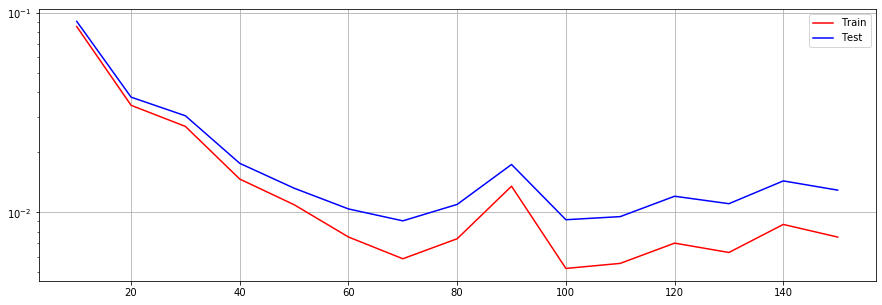

In [3]:
#### %matplotlib inline
start_time = time.time()
trained_epochs = mac1.trained_epochs
train_for_epochs = 2000
for i in range(trained_epochs, trained_epochs+train_for_epochs):
    mac1.train_for_one_epoch()

    if i % 10 == 0:
        loss, _ = mac1.test(mac1.train_data_torch, mac1.train_label_torch)
        loss_test, _ = mac1.test(mac1.test_data_torch, mac1.test_label_torch)

        rse_train = mac1.evaluation(mac1.train_data_torch, mac1.train_label_raw)
        rse_test = mac1.evaluation(mac1.test_data_torch, mac1.test_label_raw)

        mac1.loss_curve.append([i, loss, loss_test])
        if use_wandb:
            wandb.log({"Epoch": i, "Train Loss": loss, "Test Loss": loss_test, 'Eval RSE in training':np.median(rse_train,axis=0).mean(), 'Eval RSE':np.median(rse_test,axis=0).mean()})

    if i % 10 == 0:
        ETA = (time.time() - start_time) / (i - trained_epochs + 1) * (trained_epochs+train_for_epochs-i) / 60
        print(time.strftime('%H:%M:%S  ', time.localtime(time.time())), end="")
        print('ETA:{:.1f}mins '.format(ETA), end="")
        print('Epoch {}: train Loss = {:.3e}, test Loss = {:.3e}, eval = {:.3e}'.format(i, loss, loss_test, np.median(rse_test,axis=0).mean()))

    if use_wandb and i % 100 == 0:
        if not os.path.exists('saved_models/{:s}/'.format(wandb.run.id)):
            os.makedirs('saved_models/{:s}/'.format(wandb.run.id))
        torch.save({'model_state_dict':mac1.model.state_dict(), 'optimizer_state_dict': mac1.optimizer.state_dict(), 'epoch': i, 'loss_curve':mac1.loss_curve}, 'saved_models/{:s}/{:d}.pt'.format(wandb.run.id, i))

print('Training process took {:.1f} mins.'.format((time.time()-start_time)/60))

if len(mac1.loss_curve) > 0:
    plt.figure(0, figsize=(15, 5))
    plt.plot(np.array(mac1.loss_curve)[:, 0], np.array(mac1.loss_curve)[:, 1], 'r', label="Train")
    plt.plot(np.array(mac1.loss_curve)[:, 0], np.array(mac1.loss_curve)[:, 2], 'b', label="Test")
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
#     plt.show()

if mac1.use_GPU:
    print('GPU memory stats: Max Cached {:.0f} Mb, Max Reserved {:.0f} Mb, Max Allocated {:.0f} Mb'.format(
        torch.cuda.max_memory_cached(0)/1024/1024, torch.cuda.max_memory_reserved(0)/1024/1024, torch.cuda.max_memory_allocated(0)/1024/1024))

_, prediction_train_raw = mac1.test(mac1.train_data_torch, mac1.train_label_torch)
_, prediction_test_raw = mac1.test(mac1.test_data_torch, mac1.test_label_torch)

prediction_train = prediction_train_raw * mac1.label_std + mac1.label_mean
prediction_test = prediction_test_raw * mac1.label_std + mac1.label_mean
    
mse_train = np.mean(np.mean(np.square(prediction_train - mac1.train_label_raw), axis=1), axis=0)
mse_test = np.mean(np.mean(np.square(prediction_test - mac1.test_label_raw), axis=1), axis=0)

print('Denormalized: train Loss = %.3e, test Loss = %.3e' % (mse_train.mean(), mse_test.mean()))

se_train = np.linalg.norm(prediction_train - mac1.train_label_raw, 2, axis=0) / (np.linalg.norm(mac1.train_label_raw-mac1.train_label_raw.mean(axis=0), 2, axis=0) + 1e-5)
se_test = np.linalg.norm(prediction_test - mac1.test_label_raw, 2, axis=0) / (np.linalg.norm(mac1.test_label_raw-mac1.test_label_raw.mean(axis=0), 2, axis=0) + 1e-5)
rse_train = np.median(se_train, axis=0)
rse_test = np.median(se_test, axis=0)
print('Relative SE after de-normalization: train {:.3e}, test {:.3e}'.format(rse_train.mean(), rse_test.mean()))

### Evaluation
rse = mac1.evaluation(mac1.test_data_torch, mac1.test_label_raw)
print(np.median(rse,axis=0))
print('Overall:', np.median(rse,axis=0).mean())

if use_wandb:
    wandb.log({"Training Time": (time.time()-start_time)/60})
    wandb.log({"Train Relative SE": rse_train.mean()})
    wandb.log({"Test Relative SE": rse_test.mean()})
    wandb.log({"Detailed Relative SE": rse_train})
    wandb.log({"Detailed Relative SE": rse_test})
    
    wandb.log({"Prediction RSE": np.median(rse,axis=0)})
    wandb.log({"Overall": np.median(rse,axis=0).mean()})

In [4]:
# torch.save({'model_state_dict':mac1.model.state_dict(), 'optimizer_state_dict': mac1.optimizer.state_dict(), 'epoch': mac1.trained_epochs, 'loss_curve':mac1.loss_curve}, '6_23_2020.pt')

# Save model to wandb
if use_wandb:
    import os
    torch.save({'model_state_dict':mac1.model.state_dict(), 'optimizer_state_dict': mac1.optimizer.state_dict(), 'epoch': mac1.trained_epochs, 'loss_curve':mac1.loss_curve}, os.path.join(wandb.run.dir, 'model.pt'))
#     torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

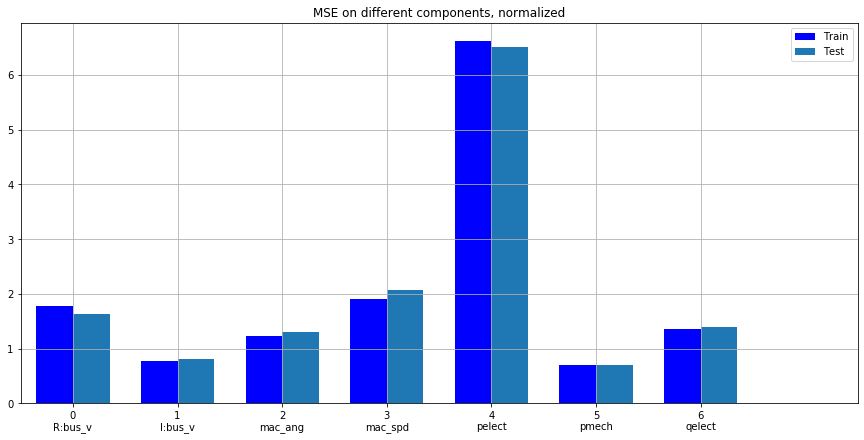

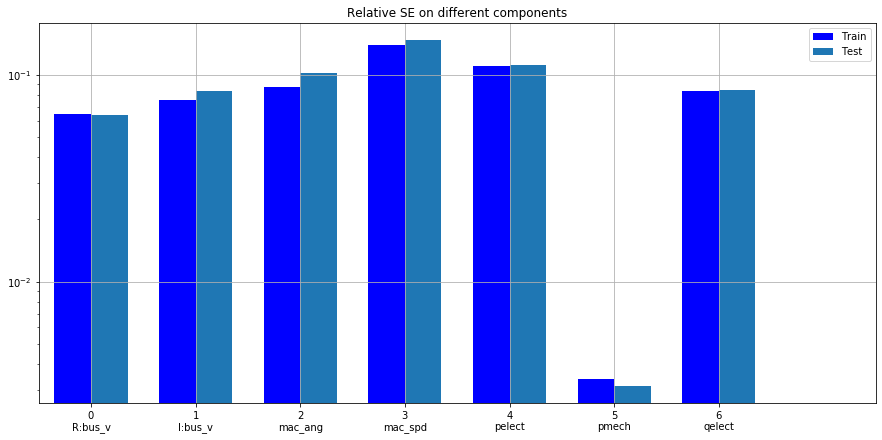

In [5]:
c = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange', 'b', 'b', 'b']
c2 = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'darkorange', 'C0', 'C0', 'C0']
x = np.arange(7)
# xticks=('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect')
xticks = ('0\nR:bus_v', '1\nI:bus_v', '2\nmac_ang', '3\nmac_spd', '4\npelect', '5\npmech', '6\nqelect')
width = 0.35

# plt.figure(1,figsize=(15,7))
# plt.bar(range(8), data_std, color=c)
# plt.xticks(range(8), ('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect'))
# plt.grid(True)
# plt.xlim([-0.5,17.5])
# # plt.ylim([0,0.001])
# plt.title('Standard Deviations on different components')

mse_train_n = np.mean(np.mean(np.square(prediction_train_raw - mac1.train_label_raw), axis=1), axis=0)
mse_test_n = np.mean(np.mean(np.square(prediction_test_raw - mac1.test_label_raw), axis=1), axis=0)

plt.figure(2, figsize=(15, 7))
plt.bar(x-width/2, mse_train_n, width, label='Train', color=c)
plt.bar(x+width/2, mse_test_n, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
# plt.ylim([0,1e-6])
plt.title('MSE on different components, normalized')


plt.figure(3, figsize=(15, 7))
plt.bar(x-width/2, rse_train, width, label='Train', color=c)
plt.bar(x+width/2, rse_test, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
plt.yscale('log')
# plt.ylim([0,1e-1])
plt.title('Relative SE on different components')
plt.show()

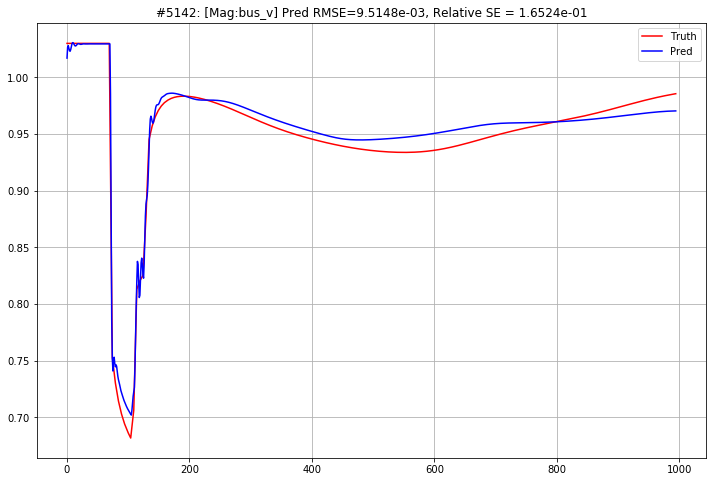

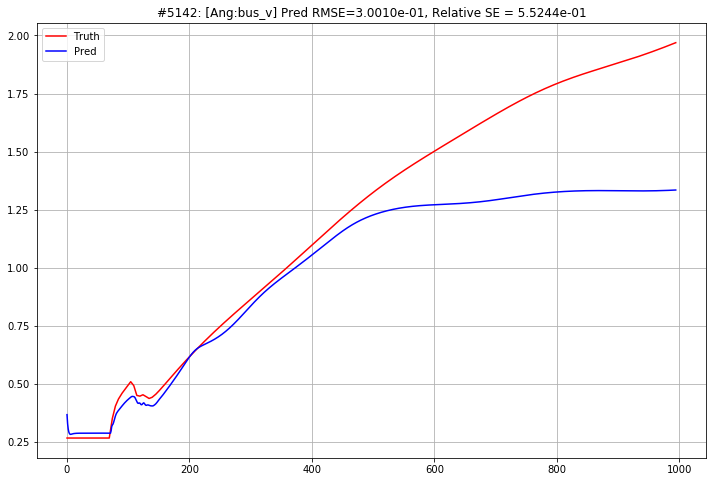

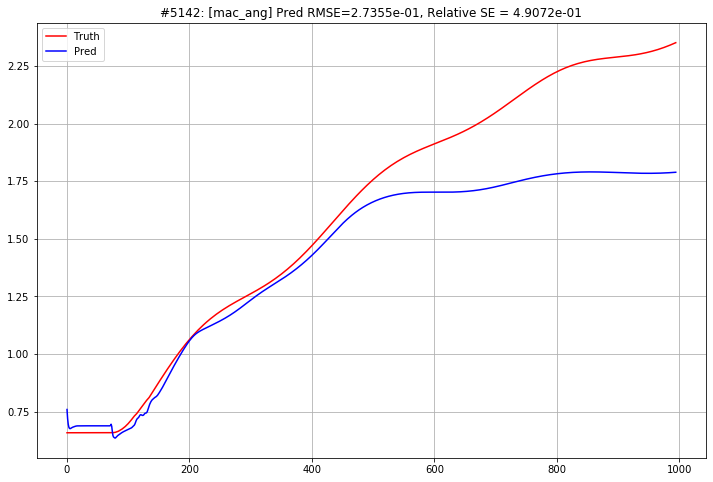

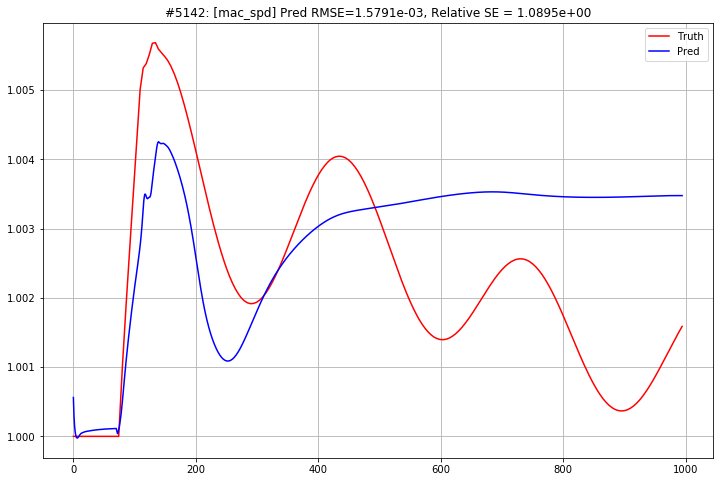

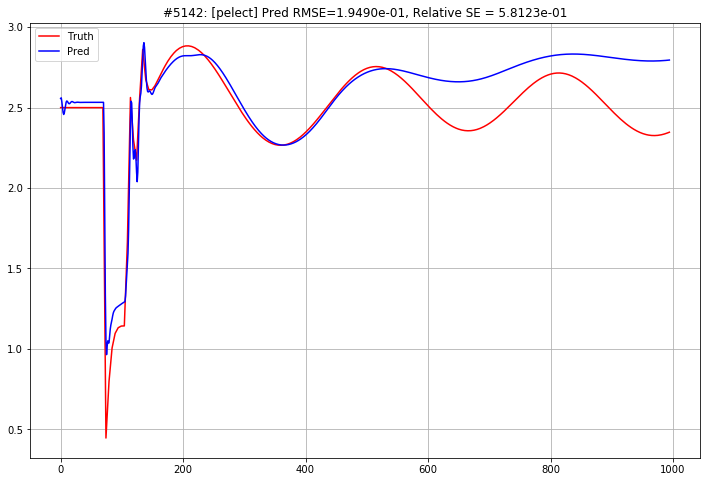

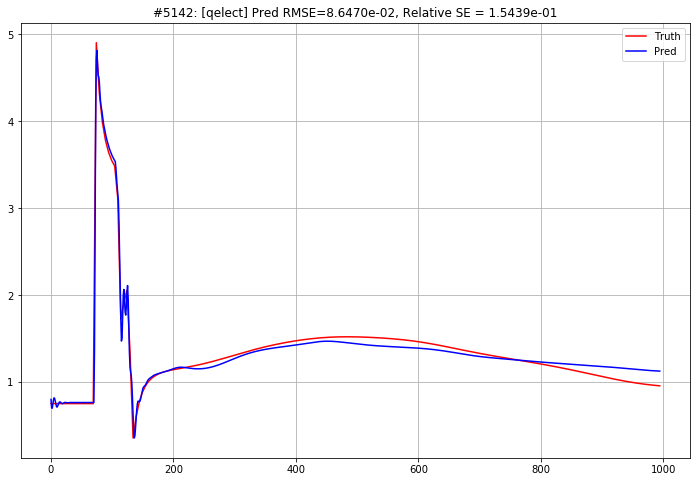

In [7]:

# entry = np.floor(np.random.uniform(low=0, high=1600, size=(1, 1))).astype(int).reshape(-1)
# entry = np.floor(np.random.uniform(low=4800, high=5200, size=(1, 1))).astype(int).reshape(-1)

entry=[5142]
# entry =[2108]  % contigency at Line 5
# entry=[4880]  % another contigency at Line 5
# entry = [4800]
# entry = mac1.sample_idx[entry]
t_max = 995

quantities = [0,1,4,5,6,7,8]  # in data indices
quantities_transform = [0, 1, -1, -1, 2, 3, 4, 5, 6]  # transform data indices to label indices
quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur_sum', 'A:cur_sum', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']

mac1.model.eval()
for i in entry:    
    filename = mac1.data['filename'][0][i][0]
    if (filename.find('a5a') > -1 or filename.find('a5.') > -1):
        print('WARRNING: {:s} contains a line-5 fault.'.format(data['filename'][0][i][0]))

    tmp_test_data, tmp_test_label = mac1.extract_data(i, t_max, 5)
    
    tmp_test_data = (tmp_test_data - mac1.data_mean) / mac1.data_std
    tmp_test_data = torch.from_numpy(tmp_test_data).to(mac1.device).float()

    output_data = np.zeros_like(tmp_test_label)
    t_start = 0
    rnn_states = mac1.model.initial_states()
    input_data_torch = tmp_test_data[t_start, :].reshape(1,1,-1)
    for t in range(t_start, t_max):
        output_data_torch, rnn_states = mac1.model(input_data_torch, rnn_states)
        output_data[t,:] = output_data_torch.data.cpu().numpy()
        if t < t_max-1:
            input_data_torch = torch.cat((output_data_torch[0,0,0:2],
                                          tmp_test_data[t+1,2:4], 
                                          output_data_torch[0,0,2:7], 
                                          tmp_test_data[t+1,9:11])
                                        ).reshape(1,1,-1)

    output_data = output_data * mac1.label_std + mac1.label_mean

    for q in range(9):
        if quantites_names[q] == 'pmech':
            continue
        if not (q in quantities):
#             plt.figure(q, figsize=(12, 8))
#             if q==2:
#                 plt.plot(range(t_max-1), tmp_test_data[1:t_max,2], 'r')
#             if q==3:
#                 plt.plot(range(t_max-1), tmp_test_data[1:t_max,3], 'r')
#             plt.grid(True)
#             plt.title('#{:d}: [{:s}]'.format(i, quantites_names[q]))
            continue
        plt.figure(q, figsize=(12, 8))
        truth_curve = tmp_test_label[:t_max, quantities_transform[q]]
        pred_curve = output_data[:t_max, quantities_transform[q]]

        plt.plot(range(t_max), truth_curve, 'r', label='Truth')
        plt.plot(range(t_max), pred_curve, 'b', label='Pred')
        plt.legend()
        plt.grid(True)

        rmse = np.sqrt(np.mean(np.square(truth_curve - pred_curve)))
        rse = np.linalg.norm(truth_curve - pred_curve, 2)/ (np.linalg.norm(truth_curve-truth_curve.mean(), 2) + 1e-6)
        plt.title('#{:d}: [{:s}] Pred RMSE={:.4e}, Relative SE = {:.4e}'.format(i, quantites_names[q], rmse, rse))

# plt.show()

# sio.savemat('example1.mat',{'label':tmp_test_label, 'data':output_data})